In [15]:
import torch as torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import time
import numpy as np

In [45]:
import pandas as pd
import os
def extract_selected_columns(input_file: str, output_file: str, particle_type: int):
    """
    Extracts specific parameters from a shower analysis .txt file, filters by total_active_pixels > 6,
    drops any rows with NaNs, adds a particle_type column, and saves or appends to output file.

    Parameters:
        input_file (str): Path to the original shower analysis file (with header).
        output_file (str): Path to the output file for selected parameters.
        particle_type (int): 0 for gamma, 1 for proton.
    """

    # Load the input data, ensuring the header is read
    df = pd.read_csv(input_file, sep='\t')

    # Add index column representing event ID (0-based)
    df.reset_index(inplace=True)
    df.rename(columns={"index": "event_id"}, inplace=True)

    # Filter: Keep only showers with total_active_pixels > 6
    df = df[df["total_active_pixels"] > 6]

    # Add particle_type column
    df["particle_type"] = particle_type

    # Select desired columns
    selected = df[["miss_distance", "alpha", "radial_distance", "azimuthal_spread", "particle_type"]]

    # Drop rows with any NaN values
    selected = selected.dropna()
    num_dropped = df.shape[0] - selected.shape[0]
    if num_dropped > 0:
        print(f"⚠️ Dropped {num_dropped} rows with NaNs from {input_file}")

    write_header = not os.path.exists(output_file) or os.path.getsize(output_file) == 0
   
    # Save or append to output file
    selected.to_csv(output_file, sep='\t', index=False, header=write_header, mode='a')


In [36]:
convention = {
    "gamma": 0,
    "proton": 1
}

In [83]:
extract_selected_columns("gamma_shower_analysis.txt", "selected_parameters.txt", 0)
extract_selected_columns("proton_shower_analysis.txt", "selected_parameters.txt", 1)


In [41]:
RAIN_MODEL = True
PLOT_METRICS = True
DATA_FILE = "selected_parameters.txt"
MODEL_SAVE_PATH = "trained_model.pth"

📊 Feature Stats - min: -2.382621438480441 max: 6.812559592566246 mean: 1.0478480869264406e-16
Epoch 1/30 - Loss: 0.2066, Train Acc: 0.9342, Test Acc: 0.9599, Time: 1.16s
Epoch 2/30 - Loss: 0.1551, Train Acc: 0.9440, Test Acc: 0.9599, Time: 2.32s
Epoch 3/30 - Loss: 0.1520, Train Acc: 0.9435, Test Acc: 0.9536, Time: 2.10s
Epoch 4/30 - Loss: 0.1443, Train Acc: 0.9490, Test Acc: 0.9582, Time: 2.14s
Epoch 5/30 - Loss: 0.1432, Train Acc: 0.9480, Test Acc: 0.9631, Time: 2.10s
Epoch 6/30 - Loss: 0.1409, Train Acc: 0.9505, Test Acc: 0.9648, Time: 2.10s
Epoch 7/30 - Loss: 0.1362, Train Acc: 0.9526, Test Acc: 0.9568, Time: 2.10s
Epoch 8/30 - Loss: 0.1375, Train Acc: 0.9518, Test Acc: 0.9662, Time: 2.12s
Epoch 9/30 - Loss: 0.1287, Train Acc: 0.9563, Test Acc: 0.9642, Time: 2.18s
Epoch 10/30 - Loss: 0.1295, Train Acc: 0.9548, Test Acc: 0.9656, Time: 2.22s
Epoch 11/30 - Loss: 0.1291, Train Acc: 0.9568, Test Acc: 0.9653, Time: 2.22s
Epoch 12/30 - Loss: 0.1307, Train Acc: 0.9542, Test Acc: 0.9642, Tim

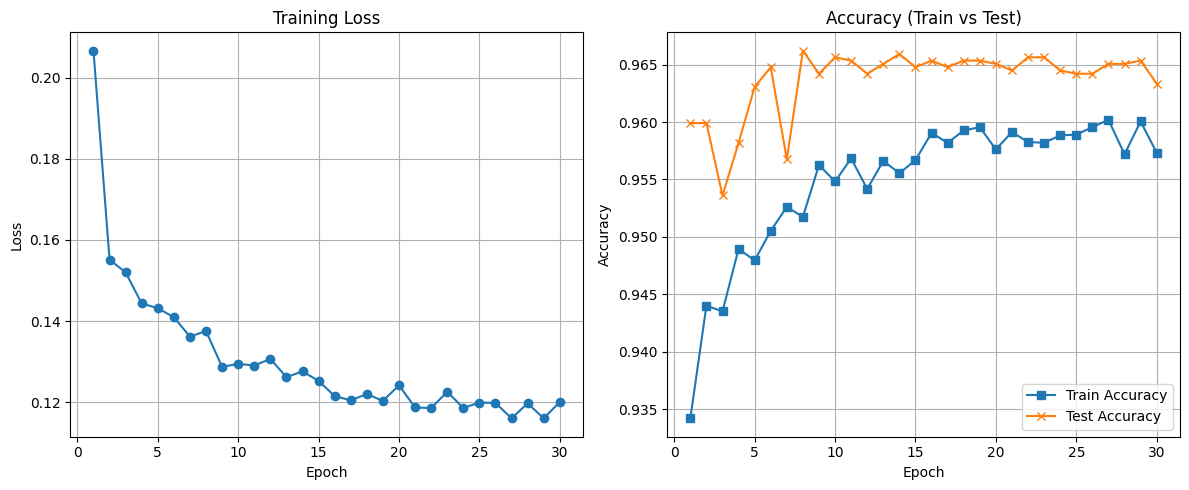


📋 Evaluation Metrics:
Accuracy   : 0.9633
Precision  : 0.9726
Recall     : 0.9617
F1 Score   : 0.9671
ROC AUC    : 0.9927
Confusion Matrix:
 [[1480   53]
 [  75 1884]]


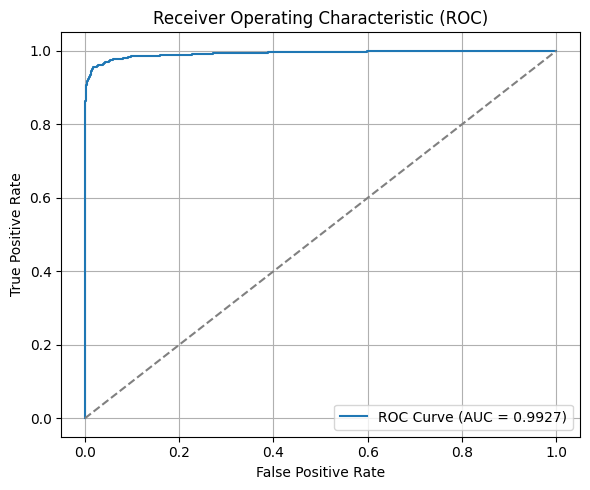

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
TRAIN_MODEL = True
PLOT_METRICS = True
DATA_FILE = "selected_parameters.txt"
MODEL_SAVE_PATH = "trained_model.pth"

def data_loader(file_path, test_ratio=0.2, batch_size=32):
    df = pd.read_csv(file_path, sep='\t')
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    features = df[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values
    labels = df["particle_type"].values
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    print("📊 Feature Stats - min:", features.min(), "max:", features.max(), "mean:", features.mean())
    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)
    dataset = TensorDataset(X, y)
    test_size = int(len(dataset) * test_ratio)
    train_size = len(dataset) - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, scaler

# 3. Define deeper classifier
class DeepShowerClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DeepShowerClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

# 4. Training loop
def train_model(model, train_loader, test_loader, epochs=30, lr=0.001, save_path="trained_model.pth"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    train_losses, train_accuracies, test_accuracies = [], [], []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        correct_train = 0
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
            predicted = (torch.sigmoid(logits) >= 0.5).long()
            correct_train += (predicted == y_batch.long()).sum().item()

        train_loss = epoch_loss / len(train_loader.dataset)
        train_acc = correct_train / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        correct = total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                logits = model(X_batch)
                predicted = (torch.sigmoid(logits) >= 0.5).long()
                correct += (predicted == y_batch.long()).sum().item()
                total += y_batch.size(0)

        acc = correct / total
        test_accuracies.append(acc)
        scheduler.step(acc)
        elapsed = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {acc:.4f}, Time: {elapsed:.2f}s")

    torch.save(model.state_dict(), save_path)
    print(f"✅ Model saved to: {save_path}")
    return train_losses, train_accuracies, test_accuracies

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader):
    model.eval()
    all_probs = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    roc_auc = roc_auc_score(all_targets, all_probs)
    conf_matrix = confusion_matrix(all_targets, all_preds)

    print("\n📋 Evaluation Metrics:")
    print(f"Accuracy   : {accuracy:.4f}")
    print(f"Precision  : {precision:.4f}")
    print(f"Recall     : {recall:.4f}")
    print(f"F1 Score   : {f1:.4f}")
    print(f"ROC AUC    : {roc_auc:.4f}")
    print("Confusion Matrix:\n", conf_matrix)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Plotting metrics
def plot_metrics(train_losses, train_accuracies, test_accuracies):
    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 's-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'x-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy (Train vs Test)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 6. Execution
if __name__ == "__main__":
    
    train_loader, test_loader, scaler = data_loader(DATA_FILE)

    if TRAIN_MODEL:
        model = DeepShowerClassifier(input_dim=4)
        train_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader)
            
        if PLOT_METRICS:
            plot_metrics(train_losses, train_accuracies, test_accuracies)

            # Evaluate on test set
    evaluate_model(model, test_loader)


In [47]:
df = pd.read_csv(DATA_FILE, sep='\t')
gamma_count = (df['particle_type'] == 0).sum()
proton_count = (df['particle_type'] == 1).sum()
print(f"Number of gamma events: {gamma_count}")
print(f"Number of proton events: {proton_count}")

Number of gamma events: 7550
Number of proton events: 9911


In [50]:
# Get test set indices from the test_loader's dataset
test_indices = test_loader.dataset.indices if hasattr(test_loader.dataset, 'indices') else range(len(test_loader.dataset))
test_df = df.iloc[list(test_indices)]

gamma_in_test = (test_df['particle_type'] == 0).sum()
proton_in_test = (test_df['particle_type'] == 1).sum()

print(f"Number of gamma events in test set: {gamma_in_test}")
print(f"Number of proton events in test set: {proton_in_test}")

Number of gamma events in test set: 1537
Number of proton events in test set: 1955


In [20]:
def load_and_preprocess_custom_data(file_path, scaler, batch_size=32):
    df = pd.read_csv(file_path)
    df.head()
    features = df[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values
    labels = df["particle_type"].values  # Should be 0 or 1

    # Use the same scaler used during training
    features = scaler.transform(features)

    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return loader


In [21]:
def evaluate_model(model, loader):
    model.eval()
    correct = total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()
            correct += (preds.view(-1) == y_batch.long()).sum().item()
            total += y_batch.size(0)
            all_preds.extend(preds.tolist())
            all_labels.extend(y_batch.tolist())

    accuracy = correct / total if total > 0 else 0
    print(f"📊 Evaluation Accuracy on custom data: {accuracy:.4f}")
    return all_preds, all_labels


In [18]:
print(evaluate_model)


<function evaluate_model at 0x7382f800f6a0>


In [70]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

TRAIN_MODEL = True
PLOT_METRICS = True
DATA_FILE = "selected_parameters.txt"
MODEL_SAVE_PATH = "trained_model.pth"


def data_loader(file_path, test_ratio=0.2, batch_size=32):
    df = pd.read_csv(file_path, sep='\t')
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    features = df[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values
    labels = df["particle_type"].values
    print("🔍 Class distribution:", np.bincount(labels.astype(int)))

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(X, y)
    test_size = int(len(dataset) * test_ratio)
    train_size = len(dataset) - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, scaler


class DeepShowerClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DeepShowerClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


def train_model(model, train_loader, test_loader, epochs=30, lr=0.001, save_path="trained_model.pth"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    train_losses, train_accuracies, test_accuracies = [], [], []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        correct_train = 0
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
            predicted = (torch.sigmoid(logits) >= 0.5).long()
            correct_train += (predicted == y_batch.long()).sum().item()

        train_loss = epoch_loss / len(train_loader.dataset)
        train_acc = correct_train / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        correct = total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                logits = model(X_batch)
                predicted = (torch.sigmoid(logits) >= 0.5).long()
                correct += (predicted == y_batch.long()).sum().item()
                total += y_batch.size(0)

        acc = correct / total
        test_accuracies.append(acc)
        scheduler.step(acc)
        elapsed = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {acc:.4f}, Time: {elapsed:.2f}s")

    torch.save(model.state_dict(), save_path)
    print(f"✅ Model saved to: {save_path}")
    return train_losses, train_accuracies, test_accuracies


def evaluate_model(model, data_loader):
    model.eval()
    all_probs = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    roc_auc = roc_auc_score(all_targets, all_probs)
    conf_matrix = confusion_matrix(all_targets, all_preds)

    print("\n📋 Evaluation Metrics:")
    print(f"Accuracy   : {accuracy:.4f}")
    print(f"Precision  : {precision:.4f}")
    print(f"Recall     : {recall:.4f}")
    print(f"F1 Score   : {f1:.4f}")
    print(f"ROC AUC    : {roc_auc:.4f}")
    print("Confusion Matrix:\n", conf_matrix)

    # Plot ROC Curve (optional, informative only)
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return default threshold = 0.5
    return 0.5



def plot_metrics(train_losses, train_accuracies, test_accuracies):
    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 's-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'x-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy (Train vs Test)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def load_and_preprocess_custom_data(file_path, scaler, batch_size=32):
    df = pd.read_csv(file_path)
    features = df[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values
    labels = df["particle_type"].values
    features = scaler.transform(features)
    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader


def inference_with_threshold(model, loader, threshold):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).long()
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y_batch.cpu().tolist())
    return np.array(all_preds), np.array(all_labels)


def show_confusion(preds, labels):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix on Custom Data")
    plt.show()
    print(classification_report(labels, preds, digits=4))


if __name__ == "__main__":
    train_loader, test_loader, scaler = data_loader(DATA_FILE)
    model = DeepShowerClassifier(input_dim=4)

    if TRAIN_MODEL:
        train_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader)
        if PLOT_METRICS:
            plot_metrics(train_losses, train_accuracies, test_accuracies)

    best_threshold = evaluate_model(model, test_loader)

    custom_data_path = "filtered_proton.csv"
    custom_loader = load_and_preprocess_custom_data(custom_data_path, scaler)

    preds, labels = inference_with_threshold(model, custom_loader, best_threshold)
    show_confusion(preds, labels)
        # Load the original filtered proton CSV
    df_custom = pd.read_csv(custom_data_path)

    # Ensure we are working with only protons
    assert (df_custom["particle_type"] == 1).all(), "Expected all labels to be protons (1)."

    # Ensure lengths match
    assert len(df_custom) == len(preds), "Mismatch in number of predictions and input data."

    # Identify false negatives: true label = 1, predicted = 0
    misclassified_mask = (labels == 1) & (preds == 0)
    misclassified_df = df_custom[misclassified_mask]

    # Save the misclassified protons
    output_file = "hard_negative_protons.csv"
    misclassified_df.to_csv(output_file, index=False)
    print(f"🛠️ Found {len(misclassified_df)} misclassified protons.")
    print(f"📁 Saved to: {output_file}")



🔍 Class distribution: [ 7550 11011]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128])

🔍 Class distribution: [ 7550 11011]
✅ Selected threshold = 0.942 to keep proton misclassification < 5.00%

📋 Evaluation at Threshold = 0.942
Accuracy   : 0.9402
Precision  : 0.9649
Recall     : 0.9334
F1 Score   : 0.9489
ROC AUC    : 0.9806
Confusion Matrix:
 [[1429   75]
 [ 147 2061]]


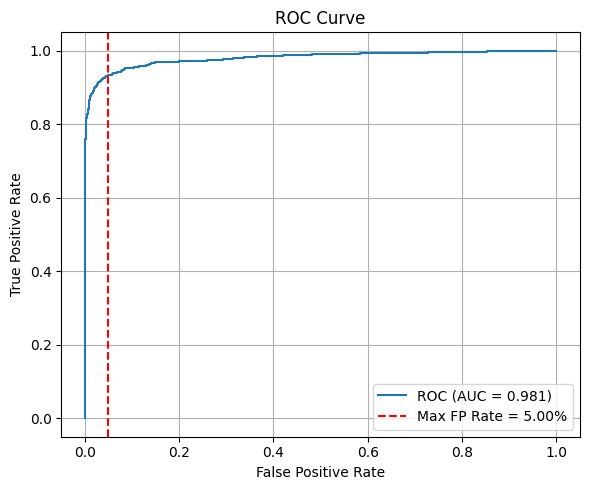

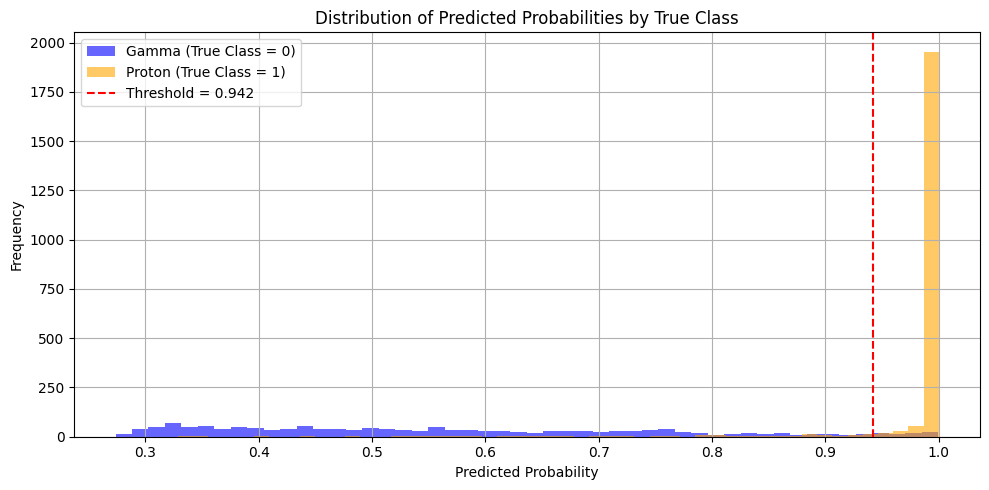

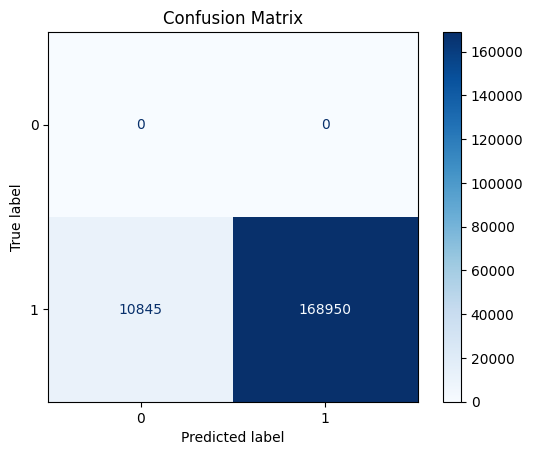

              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000         0
         1.0     1.0000    0.9397    0.9689    179795

    accuracy                         0.9397    179795
   macro avg     0.5000    0.4698    0.4845    179795
weighted avg     1.0000    0.9397    0.9689    179795

🛠️ Found 10845 misclassified protons.
📁 Saved to: hard_negative_protons.csv


/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/working.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/working.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/working.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_divisio

In [82]:
if __name__ == "__main__":
    # Load data and scaler
    train_loader, test_loader, scaler = data_loader(DATA_FILE)

    # Load trained model
    model = DeepShowerClassifier(input_dim=4)
    model.load_state_dict(torch.load("trained_model.pth", map_location=torch.device("cpu")))
    model.eval()

    # Evaluate model on test set and find best threshold
    best_threshold = evaluate_model(model, test_loader)

    # Inference on custom proton data
    custom_data_path = "filtered_proton.csv"
    custom_loader = load_and_preprocess_custom_data(custom_data_path, scaler)

    preds, labels = inference_with_threshold(model, custom_loader, best_threshold)
    show_confusion(preds, labels)

    # Load the original filtered proton CSV
    df_custom = pd.read_csv(custom_data_path)

    # Sanity checks
    assert (df_custom["particle_type"] == 1).all(), "Expected all labels to be protons (1)."
    assert len(df_custom) == len(preds), "Mismatch in number of predictions and input data."

    # Identify false negatives (true = 1, pred = 0)
    misclassified_mask = (labels == 1) & (preds == 0)
    misclassified_df = df_custom[misclassified_mask]

    # Save misclassified proton events
    output_file = "hard_negative_protons.csv"
    misclassified_df.to_csv(output_file, index=False)
    print(f"🛠️ Found {len(misclassified_df)} misclassified protons.")
    print(f"📁 Saved to: {output_file}")


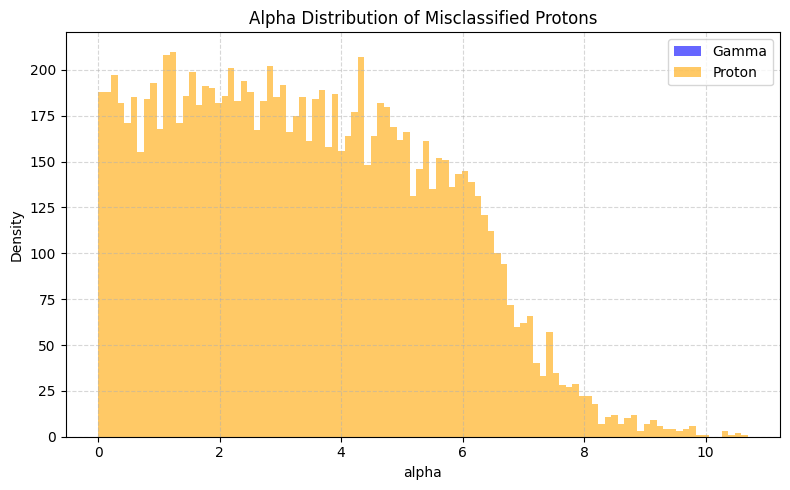

In [108]:
import pandas as pd

# Load the misclassified proton events
misclassified_df = pd.read_csv("hard_negative_protons.csv")

# Manually assign predicted label (for compatibility with plot function)
misclassified_df["predicted_particle_type"] = 1  # since all are true protons, and predicted as gamma (0), but we'll mark as 1 to show count

# Plot alpha distribution
plot_parameter_distribution_from_df(
    df=misclassified_df,
    parameter="alpha",
    title="Alpha Distribution of Misclassified Protons"
)


In [98]:
hard_negatives = pd.read_csv("hard_negative_protons.csv")

# Randomly select 11,000 rows
selected_hard_negatives = hard_negatives.sample(n=900, random_state=42)

# Load the existing selected_parameters.txt
selected_df = pd.read_csv("selected_parameters.txt", sep='\t')

# Append the new hard negatives
combined_df = pd.concat([selected_df, selected_hard_negatives], ignore_index=True)

# Save back to selected_parameters.txt
combined_df.to_csv("selected_parameters.txt", sep='\t', index=False)

print("✅ Appended 900 hard negative protons to selected_parameters.txt")

✅ Appended 900 hard negative protons to selected_parameters.txt


In [107]:
proton_total = (labels == 1).sum()
proton_misclassified = ((labels == 1) & (preds == 0)).sum()
proton_rejection_rate = proton_misclassified / proton_total
print(f"Proton rejection rate: {proton_rejection_rate:.2%}")



Proton rejection rate: 6.32%


In [109]:
df = pd.read_csv("selected_parameters.txt", sep='\\t')
print(df['particle_type'].value_counts())


particle_type
1    10811
0     7550
Name: count, dtype: int64


/tmp/ipykernel_3497/2396976655.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("selected_parameters.txt", sep='\\t')


In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import os

# === Step 1: Load the trained model ===


# Load trained model
model = DeepShowerClassifier(input_dim=4)
model.load_state_dict(torch.load("trained_model.pth"))
model.eval()



# === Step 3: Load and preprocess real data ===
real_data_path = "filtered_source_1.csv"  # Replace with your actual data path

# Load real-world shower data
df_real = pd.read_csv(real_data_path)

# Safety: Drop NaN rows
df_real = df_real.dropna()

# Optional: Filter based on total_active_pixels if present
if "total_active_pixels" in df_real.columns:
    df_real = df_real[df_real["total_active_pixels"] > 6]

# Select only the required 4 features
features_real = df_real[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values

# Scale the features using training scaler
features_scaled = scaler.transform(features_real)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features_scaled, dtype=torch.float32)

# Prepare DataLoader for batch processing
real_loader = DataLoader(TensorDataset(X_tensor), batch_size=512, shuffle=False)

print("✅ Real data loaded and preprocessed.")


✅ Real data loaded and preprocessed.


In [6]:
def classify_real_data(model, data_loader, threshold):
    """
    Classifies real-world shower data using a trained model.

    Parameters:
        model: Trained PyTorch model.
        data_loader: DataLoader for real data.
        threshold (float): Classification threshold (default 0.5).

    Returns:
        DataFrame with original event features and predicted labels (0: gamma, 1: proton).
    """
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0]
            outputs = model(inputs).squeeze()
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).long()
            all_preds.extend(preds.tolist())

    return all_preds

In [20]:
# Step 1: Get predictions
predicted_labels = classify_real_data(model, real_loader, threshold=best_thresh)  # or 0.5 if you want to fix it

# Step 2: Append predictions to your real data
df_real["predicted_particle_type"] = predicted_labels  # 0 = gamma, 1 = proton

# Step 3: Save or display results
output_path = "classified_real_data.csv"
df_real.to_csv(output_path, index=False)

print(f"📁 Saved classified data to: {output_path}")
df_real.head()


📁 Saved classified data to: classified_real_data.csv


,miss_distance,alpha,radial_distance,azimuthal_spread,predicted_particle_type
0,2.15,53.18,2.68,1.16,1
1,5.38,69.76,5.73,0.77,1
2,3.83,32.82,7.07,0.81,1
3,3.11,60.49,3.58,1.37,1
4,1.69,23.56,4.24,0.78,1


In [21]:
# Count predicted gamma and proton
num_gamma = (df_real["predicted_particle_type"] == 0).sum()
num_proton = (df_real["predicted_particle_type"] == 1).sum()

print(f"🔬 Number of Gamma events predicted: {num_gamma}")
print(f"🧪 Number of Proton events predicted: {num_proton}")


🔬 Number of Gamma events predicted: 11
🧪 Number of Proton events predicted: 10446


In [22]:
import matplotlib.pyplot as plt

def plot_parameter_distribution_from_df(df, parameter, title, bin_count=100):
    """
    Plot histogram of a given parameter from classified real-world DataFrame for gamma and proton.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'predicted_particle_type' column (0 = gamma, 1 = proton)
        parameter (str): Column name to plot
        title (str): Plot title
        bin_count (int): Number of bins in the histogram
    """

    if parameter not in df.columns:
        raise ValueError(f"Parameter '{parameter}' not found in DataFrame.")

    gamma_vals = df[df["predicted_particle_type"] == 0][parameter]
    proton_vals = df[df["predicted_particle_type"] == 1][parameter]

    plt.figure(figsize=(8, 5))
    plt.hist(gamma_vals, bins=bin_count, alpha=0.6, label='Gamma', color='blue')

    
    plt.title(title)
    plt.xlabel(parameter)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


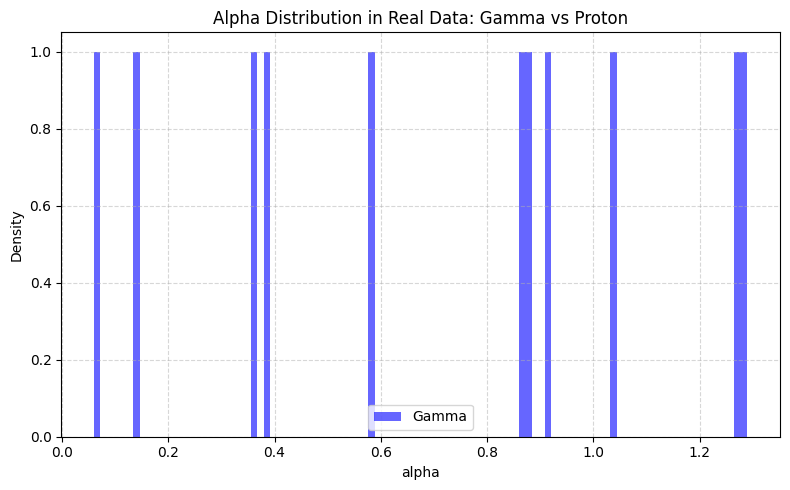

In [23]:
plot_parameter_distribution_from_df(
    df=df_real,
    parameter="alpha",
    title="Alpha Distribution in Real Data: Gamma vs Proton"
)


📊 Full dataset class distribution: [1101 9911]
✅ Stratified split maintained:
  Train class distribution: [ 881 7928]
  Test  class distribution: [ 220 1983]
📦 Saved new best model with test acc: 0.9251
Epoch 1/50 - Loss: 0.0237, Train Acc: 0.8695, Test Acc: 0.9251, Time: 0.83s
📦 Saved new best model with test acc: 0.9505
Epoch 2/50 - Loss: 0.0141, Train Acc: 0.9312, Test Acc: 0.9505, Time: 0.82s
📦 Saved new best model with test acc: 0.9582
Epoch 3/50 - Loss: 0.0129, Train Acc: 0.9329, Test Acc: 0.9582, Time: 0.80s
Epoch 4/50 - Loss: 0.0128, Train Acc: 0.9314, Test Acc: 0.9546, Time: 0.80s
Epoch 5/50 - Loss: 0.0118, Train Acc: 0.9368, Test Acc: 0.9542, Time: 0.80s
Epoch 6/50 - Loss: 0.0110, Train Acc: 0.9409, Test Acc: 0.9396, Time: 0.81s
Epoch 7/50 - Loss: 0.0105, Train Acc: 0.9464, Test Acc: 0.9542, Time: 0.80s
Epoch 8/50 - Loss: 0.0109, Train Acc: 0.9447, Test Acc: 0.9478, Time: 0.80s
Epoch 9/50 - Loss: 0.0107, Train Acc: 0.9459, Test Acc: 0.9532, Time: 0.80s
📦 Saved new best model 

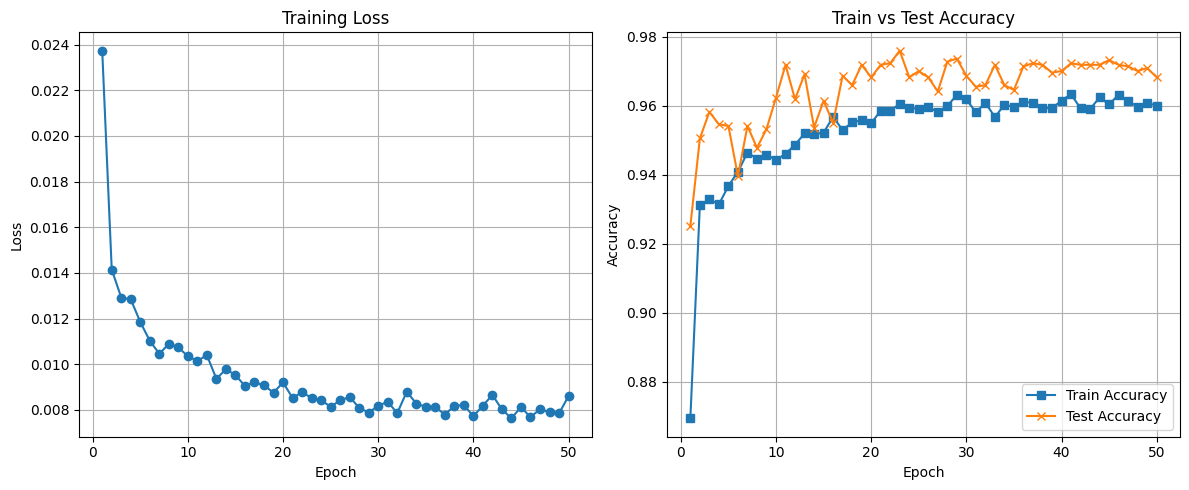

✅ Selected threshold = 0.234 (False Gamma Rate ≤ 0.001)

📋 Evaluation at Threshold = 0.234
Accuracy   : 0.9106
Precision  : 0.9100
Recall     : 0.9995
F1 Score   : 0.9527
ROC AUC    : 0.9964
Confusion Matrix:
 [[  24  196]
 [   1 1982]]


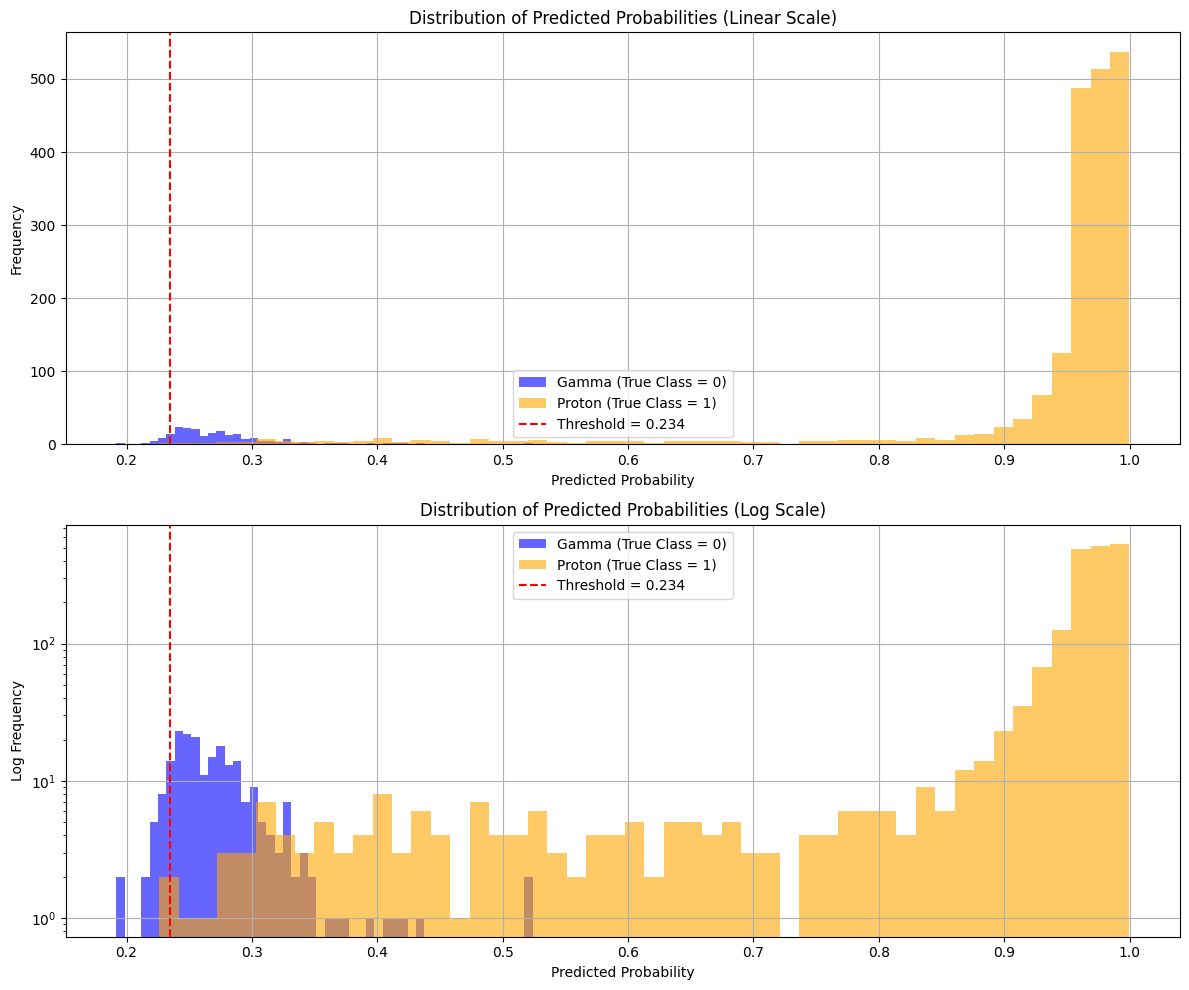


❌ False Negatives (Gamma → Proton): 196 / 220 (89.09%)


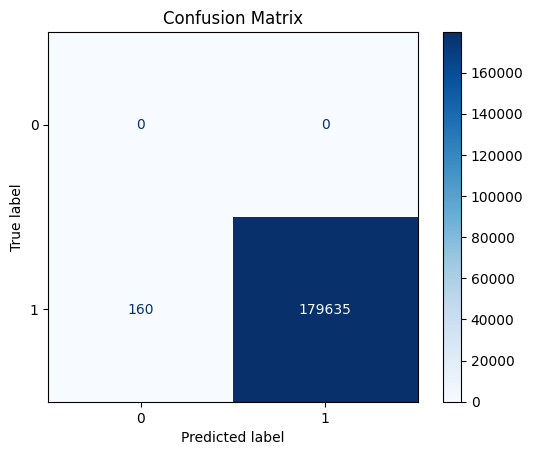

              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000         0
         1.0     1.0000    0.9991    0.9996    179795

    accuracy                         0.9991    179795
   macro avg     0.5000    0.4996    0.4998    179795
weighted avg     1.0000    0.9991    0.9996    179795

🛠️ Misclassified protons: 160 saved to 'hard_negative_protons.csv'


/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/working.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/working.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/working.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_divisio

In [17]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

TRAIN_MODEL = True
PLOT_METRICS = True
DATA_FILE = "proton_heavy_selected_parameters.txt"
MODEL_SAVE_PATH = "trained_model.pth"


def data_loader(file_path, test_ratio=0.2, batch_size=32):
    df = pd.read_csv(file_path, sep='\t')
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    features = df[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values
    labels = df["particle_type"].values.astype(int)
    print("🔍 Class distribution:", np.bincount(labels))

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(X, y)
    test_size = int(len(dataset) * test_ratio)
    train_size = len(dataset) - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, scaler


class DeepShowerClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DeepShowerClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


def train_model(model, train_loader, test_loader, epochs=50, lr=0.001, save_path="trained_model.pth"):
    criterion = FocalLoss(alpha=0.25, gamma=2.0)  # You can tune alpha/gamma
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    train_losses, train_accuracies, test_accuracies = [], [], []
    best_acc = 0.0  # Track the best test accuracy
    best_model_state = None

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        correct_train = 0
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
            predicted = (torch.sigmoid(logits) >= 0.5).long()
            correct_train += (predicted == y_batch.long()).sum().item()

        train_loss = epoch_loss / len(train_loader.dataset)
        train_acc = correct_train / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Evaluation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                logits = model(X_batch)
                predicted = (torch.sigmoid(logits) >= 0.5).long()
                correct += (predicted == y_batch.long()).sum().item()
                total += y_batch.size(0)

        acc = correct / total
        test_accuracies.append(acc)
        scheduler.step(acc)
        elapsed = time.time() - start_time

        # Save best model
        if acc > best_acc:
            best_acc = acc
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            print(f"📦 Saved new best model with test acc: {acc:.4f}")

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {acc:.4f}, Time: {elapsed:.2f}s")

    print(f"✅ Best model saved to: {save_path} with test acc: {best_acc:.4f}")
    return train_losses, train_accuracies, test_accuracies

def inference_with_threshold(model, loader, threshold):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).long()
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y_batch.cpu().tolist())
    return np.array(all_preds), np.array(all_labels)


def plot_probability_distribution(probabilities, labels, threshold):
    probabilities = np.array(probabilities)
    labels = np.array(labels)

    plt.figure(figsize=(12, 10))

    # 🔹 Subplot 1: Regular Histogram
    plt.subplot(2, 1, 1)
    plt.hist(probabilities[labels == 0], bins=50, alpha=0.6, label="Gamma (True Class = 0)", color='blue')
    plt.hist(probabilities[labels == 1], bins=50, alpha=0.6, label="Proton (True Class = 1)", color='orange')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.3f}')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.title("Distribution of Predicted Probabilities (Linear Scale)")
    plt.legend()
    plt.grid(True)

    # 🔹 Subplot 2: Log-Scale Histogram
    plt.subplot(2, 1, 2)
    plt.hist(probabilities[labels == 0], bins=50, alpha=0.6, label="Gamma (True Class = 0)", color='blue')
    plt.hist(probabilities[labels == 1], bins=50, alpha=0.6, label="Proton (True Class = 1)", color='orange')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.3f}')
    plt.yscale("log")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Log Frequency")
    plt.title("Distribution of Predicted Probabilities (Log Scale)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def evaluate_model(model, loader, max_fp_rate=0.001, min_gamma_threshold=0.1, threshold_range=None):
    if threshold_range is None:
        threshold_range = np.linspace(1.0, 0.0, 500)

    model.eval()
    all_probs, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    best_thresh = None
    for threshold in threshold_range:
        preds = (all_probs >= threshold).astype(int)

        # ❗ False Gamma = Proton (1) misclassified as Gamma (0)
        false_gammas = np.sum((all_targets == 1) & (preds == 0))
        total_protons = np.sum(all_targets == 1)
        false_gamma_rate = false_gammas / (total_protons + 1e-8)

        if false_gamma_rate <= max_fp_rate:
            best_thresh = threshold
            break  # ✅ Earliest threshold that satisfies condition

    if best_thresh is None:
        best_thresh = 0.3  # Predict all as protons
        print(f"⚠️ No threshold satisfies False Gamma Rate < {max_fp_rate*100:.2f}%. Predicting all as proton.")
    else:
        print(f"✅ Selected threshold = {best_thresh:.3f} (False Gamma Rate ≤ {max_fp_rate:.3f})")

    if best_thresh < min_gamma_threshold:
        print(f"🔒 Enforcing min gamma threshold: Raised to {min_gamma_threshold:.3f}")
        best_thresh = min_gamma_threshold

    # Final prediction with best threshold
    preds = (all_probs >= best_thresh).astype(int)
    acc = accuracy_score(all_targets, preds)
    precision = precision_score(all_targets, preds, zero_division=0)
    recall = recall_score(all_targets, preds, zero_division=0)
    f1 = f1_score(all_targets, preds, zero_division=0)
    auc_score = roc_auc_score(all_targets, all_probs)
    cm = confusion_matrix(all_targets, preds)

    print(f"\n📋 Evaluation at Threshold = {best_thresh:.3f}")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {precision:.4f}")
    print(f"Recall     : {recall:.4f}")
    print(f"F1 Score   : {f1:.4f}")
    print(f"ROC AUC    : {auc_score:.4f}")
    print("Confusion Matrix:\n", cm)

    plot_probability_distribution(all_probs, all_targets, best_thresh)

    # ❌ Count false negatives (true gamma misclassified as proton)
    true_gammas = (all_targets == 0)
    misclassified_gammas = (preds == 1) & (true_gammas)
    num_false_negatives = np.sum(misclassified_gammas)
    total_gammas = np.sum(true_gammas)
    print(f"\n❌ False Negatives (Gamma → Proton): {num_false_negatives} / {total_gammas} ({100 * num_false_negatives / total_gammas:.2f}%)")

    return best_thresh


def stratified_data_loader(file_path, test_ratio=0.2, batch_size=32):
    """
        Loads proton-heavy dataset with consistent class ratio in train/test using stratified split.
        
        Parameters:
        - file_path: Path to the proton-heavy dataset (TSV format)
        - test_ratio: Proportion of test data
        - batch_size: DataLoader batch size

        Returns:
        - train_loader, test_loader, scaler
    """

    from sklearn.model_selection import train_test_split

    df = pd.read_csv(file_path, sep="\t")
    features = df[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values
    labels = df["particle_type"].values.astype(int)

    print("📊 Full dataset class distribution:", np.bincount(labels))

    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        features_scaled, labels,
        test_size=test_ratio,
        random_state=42,
        stratify=labels
    )

    print("✅ Stratified split maintained:")
    print("  Train class distribution:", np.bincount(y_train))
    print("  Test  class distribution:", np.bincount(y_test))

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, scaler



def show_confusion(preds, labels):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(labels, preds, digits=4))


def load_and_preprocess_custom_data(file_path, scaler, batch_size=32):
    df = pd.read_csv(file_path)
    features = df[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values
    labels = df["particle_type"].values
    features = scaler.transform(features)
    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)


def plot_metrics(train_losses, train_accuracies, test_accuracies):
    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss'); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 's-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'x-', label='Test Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Train vs Test Accuracy')
    plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()




if __name__ == "__main__":
    train_loader, test_loader, scaler = stratified_data_loader(DATA_FILE, batch_size=32)
    model = DeepShowerClassifier(input_dim=4)

    if TRAIN_MODEL:
        train_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader)
        if PLOT_METRICS:
            plot_metrics(train_losses, train_accuracies, test_accuracies)

    best_thresh = evaluate_model(model, test_loader,  max_fp_rate=0.001, min_gamma_threshold=0.1)

    # Inference on new data
    custom_path = "filtered_proton.csv"
    custom_loader = load_and_preprocess_custom_data(custom_path, scaler)
    preds, labels = inference_with_threshold(model, custom_loader, best_thresh)
    show_confusion(preds, labels)

    df_custom = pd.read_csv(custom_path)
    misclassified = (labels == 1) & (preds == 0)
    misclassified_df = df_custom[misclassified]
    misclassified_df.to_csv("hard_negative_protons.csv", index=False)
    print(f"🛠️ Misclassified protons: {len(misclassified_df)} saved to 'hard_negative_protons.csv'")



In [84]:
import pandas as pd

def create_proton_heavy_dataset(input_file: str, output_file: str, gamma_ratio: float = 0.1):
    """
    Creates a proton-heavy dataset (default 90% protons, 10% gammas) and writes to a new file.

    Parameters:
    - input_file: str – Path to the original dataset file (e.g., 'selected_parameters.txt')
    - output_file: str – Path to save the new proton-heavy dataset
    - gamma_ratio: float – Proportion of gamma events in the output (default: 0.1)
    """

    # Load data
    df = pd.read_csv(input_file, sep="\t")
    
    # Split based on particle_type
    protons = df[df["particle_type"] == 1]
    gammas = df[df["particle_type"] == 0]

    # Sort gammas by 'alpha' and select the lowest-alpha ones
    gammas_sorted = gammas.sort_values(by="alpha")
    max_gammas = int(len(protons) * gamma_ratio / (1 - gamma_ratio))  # Ensure desired 90-10 split
    selected_gammas = gammas_sorted.head(max_gammas)

    # Combine and shuffle
    final_df = pd.concat([protons, selected_gammas])
    final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the new dataset
    final_df.to_csv(output_file, sep="\t", index=False)
    print(f"✅ Proton-heavy dataset saved to: {output_file}")
    print(f"📊 New class distribution: {final_df['particle_type'].value_counts().to_dict()}")


In [85]:
create_proton_heavy_dataset(
    input_file="selected_parameters.txt",
    output_file="proton_heavy_selected_parameters.txt"
)


✅ Proton-heavy dataset saved to: proton_heavy_selected_parameters.txt
📊 New class distribution: {1: 9911, 0: 1101}


In [ ]:
# Step 1: Get predictions
predicted_labels = classify_real_data(model, real_loader, threshold=best_threshold)  # or 0.5 if you want to fix it

# Step 2: Append predictions to your real data
df_real["predicted_particle_type"] = predicted_labels  # 0 = gamma, 1 = proton

# Step 3: Save or display results
output_path = "classified_real_data.csv"
df_real.to_csv(output_path, index=False)

print(f"📁 Saved classified data to: {output_path}")
df_real.head()


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: logits (before sigmoid), targets: float tensor (0 or 1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probas = torch.sigmoid(inputs)
        pt = probas * targets + (1 - probas) * (1 - targets)
        focal_weight = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = focal_weight * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


In [131]:
def stratified_data_loader(file_path, test_ratio=0.2, batch_size=32, hard_negative_path=None):
    """
    Loads dataset with optional 900 hard negatives added to training set only.

    Parameters:
    - file_path: Path to main dataset (TSV format)
    - test_ratio: Proportion of test data
    - batch_size: DataLoader batch size
    - hard_negative_path: Optional path to CSV containing hard negative protons

    Returns:
    - train_loader, test_loader, scaler
    """

    from sklearn.model_selection import train_test_split

    # 🔹 Load main dataset
    df_main = pd.read_csv(file_path, sep="\t")
    features_main = df_main[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values
    labels_main = df_main["particle_type"].values.astype(int)

    print("📊 Main dataset class distribution:", np.bincount(labels_main))

    # 🔹 Stratified split of original data
    X_train_main, X_test, y_train_main, y_test = train_test_split(
        features_main,
        labels_main,
        test_size=test_ratio,
        random_state=42,
        stratify=labels_main
    )

    # 🔹 Optionally load and add 900 hard negatives to training set
    if hard_negative_path is not None:
        df_hard = pd.read_csv(hard_negative_path)
        selected_hard_negatives = df_hard.sample(n=900, random_state=42)

        X_hard = selected_hard_negatives[["miss_distance", "alpha", "radial_distance", "azimuthal_spread"]].values
        y_hard = np.ones(900, dtype=int)  # ensure proton class label

        print(f"➕ Added 900 hard negatives to training data")
        # Concatenate with training data
        X_train = np.concatenate([X_train_main, X_hard], axis=0)
        y_train = np.concatenate([y_train_main, y_hard], axis=0)
    else:
        X_train = X_train_main
        y_train = y_train_main

    # 🔹 Normalize with scaler (fit on full training set including hard negatives)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 🔹 Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # 🔹 Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("✅ Final training class distribution:", np.bincount(y_train))
    print("✅ Final test     class distribution:", np.bincount(y_test))

    return train_loader, test_loader, scaler
